In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from implemention.utils.load import *

X_train, y_train, X_val, y_val, X_test, y_test = load_train_data()
# test = load_test_data()
data = {}
data['X_val'] = X_val
data['y_val'] = y_val

In [17]:
data['X_train'] = X_train[-50:]
data['y_train'] = y_train[-50:]

In [30]:
import numpy as np

from implemention.utils.layers import *
from implemention.utils.fast_layers import *
from implemention.utils.layer_utils import *

class CNNN(object):
    """
    Structure: 
        input -> (conv -> batchnorm -> relu -> conv -> batchnorm -> relu -> pool) * 3
              -> (affine -> batchnorm -> relu) * 2 -> affine -> softmax
    """
    def __init__(self, input_dim=(1, 48, 48), num_filters=32, filter_size=3,
                 hidden_dim=500, num_classes=7, weight_scale=1e-3, reg=0.01,
                 dtype=np.float64):
        
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        self.filter_size = filter_size
        
        # initialize the weights and bias
        C, H, W = input_dim
        # N, 1, 48 ,48
        
        # conv -> relu #1 
        #weight_scale = np.sqrt(2.0/(filter_size*filter_size))
        self.params['W1'] = weight_scale * np.random.randn(num_filters, C, filter_size, filter_size)
        self.params['b1'] = np.zeros(num_filters)   
        # spatial batchnorm
        self.params['gamma1'] = np.ones(C)
        self.params['beta1'] = np.zeros(C)
        
        # conv -> relu -> pool #1
        #weight_scale = np.sqrt(2.0/(filter_size*filter_size))
        self.params['W2'] = weight_scale * np.random.randn(num_filters, num_filters, filter_size, filter_size)
        self.params['b2'] = np.zeros(num_filters)
        # spatial batchnorm
        self.params['gamma2'] = np.ones(num_filters)
        self.params['beta2'] = np.zeros(num_filters)
        
        # N, 32, 24, 24
        C, H, W = num_filters, (H-2)//2+1, (W-2)//2+1
        
        # conv -> relu #2 
        self.params['W3'] = weight_scale * np.random.randn(num_filters, num_filters, filter_size, filter_size)
        self.params['b3'] = np.zeros(num_filters)
        # spatial batchnorm
        self.params['gamma3'] = np.ones(num_filters)
        self.params['beta3'] = np.zeros(num_filters)
        
        # conv -> relu -> pool #2
        self.params['W4'] = weight_scale * np.random.randn(num_filters, num_filters, filter_size, filter_size)
        self.params['b4'] = np.zeros(num_filters)
        # spatial batchnorm
        self.params['gamma4'] = np.ones(num_filters)
        self.params['beta4'] = np.zeros(num_filters)
        
        # N, 32, 12, 12
        C, H, W = num_filters, (H-2)//2+1, (W-2)//2+1
        
        # conv -> relu #3
        self.params['W5'] = weight_scale * np.random.randn(num_filters, num_filters, filter_size, filter_size)
        self.params['b5'] = np.zeros(num_filters)
        # spatial batchnorm
        self.params['gamma5'] = np.ones(num_filters)
        self.params['beta5'] = np.zeros(num_filters)
        # conv -> relu -> pool #3
        self.params['W6'] = weight_scale * np.random.randn(num_filters, num_filters, filter_size, filter_size)
        self.params['b6'] = np.zeros(num_filters)
        # spatial batchnorm
        self.params['gamma6'] = np.ones(num_filters)
        self.params['beta6'] = np.zeros(num_filters)
        # N, 32, 6, 6
        C, H, W = num_filters, (H-2)//2+1, (W-2)//2+1
        
        # affine -> relu 1
        #weight_scale = np.sqrt(1/num_filters*H*W)
        self.params['W7'] = weight_scale * np.random.randn(num_filters*H*W, hidden_dim)
        self.params['b7'] = np.zeros(hidden_dim)
        # batchnorm
        self.params['gamma7'] = np.ones(hidden_dim)
        self.params['beta7'] = np.zeros(hidden_dim)
        # affine -> relu 2
        #weight_scale = np.sqrt(1/hidden_dim)
        self.params['W8'] = weight_scale * np.random.randn(hidden_dim, hidden_dim)
        self.params['b8'] = np.zeros(hidden_dim)
        # spatial batchnorm
        self.params['gamma8'] = np.ones(hidden_dim)
        self.params['beta8'] = np.zeros(hidden_dim)
        
        # affine
        #weight_scale = np.sqrt(1/hidden_dim)
        self.params['W9'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b9'] = np.zeros(num_classes)
        
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)
    
    
    def loss(self, X, y=None):
                
        filter_size = self.filter_size
        conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}
        #dropout_param = {'mode': 'train', 'p': dropout}
        scores = None
        caches = []
        
        
        # conv -> batchnorm -> relu #1
        out,cache = conv_bn_relu_forward(X, self.params['W1'], self.params['b1'],
                             self.params['gamma1'], self.params['beta1'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # conv -> batchnorm -> relu 
        out,cache = conv_bn_relu_forward(out, self.params['W2'], self.params['b2'],
                             self.params['gamma2'], self.params['beta2'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # 2*2 maxpool
        out, cache = max_pool_forward_fast(out, pool_param)
        caches.append(cache)
        
        # conv -> batchnorm -> relu #2
        out,cache = conv_bn_relu_forward(out, self.params['W3'], self.params['b3'],
                             self.params['gamma3'], self.params['beta3'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # conv -> batchnorm -> relu 
        out,cache = conv_bn_relu_forward(out, self.params['W4'], self.params['b4'],
                             self.params['gamma4'], self.params['beta4'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # 2*2 maxpool
        out, cache = max_pool_forward_fast(out, pool_param)
        caches.append(cache)
        
        # conv -> batchnorm -> relu #3
        out,cache = conv_bn_relu_forward(out, self.params['W5'], self.params['b5'],
                             self.params['gamma5'], self.params['beta5'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # conv -> batchnorm -> relu 
        out,cache = conv_bn_relu_forward(out, self.params['W6'], self.params['b6'],
                             self.params['gamma6'], self.params['beta6'], conv_param, bn_param={'mode':'train'})
        caches.append(cache)
        # 2*2 maxpool
        out, cache = max_pool_forward_fast(out, pool_param)
        caches.append(cache)
        
        # affine -> bn -> relu #1
        out, cache = affine_bn_relu_forward(out, self.params['W7'], self.params['b7'],
                                            self.params['gamma7'], self.params['beta7'], bn_param={'mode':'train'})
        caches.append(cache)
        
        # affine -> bn -> relu #2
        out, cache = affine_bn_relu_forward(out, self.params['W8'], self.params['b8'],
                                            self.params['gamma8'], self.params['beta8'], bn_param={'mode':'train'})
        caches.append(cache)
        
        # affine
        scores, cache = affine_forward(out, self.params['W9'], self.params['b9'])
        caches.append(cache)
        
        if y is None:
            return scores

        loss, grads = 0, {}
        
        loss, dscores = softmax_loss(scores, y)
        
        dout, grads['W9'], grads['b9'] = affine_backward(dscores, caches.pop())     # affine
        grads['W9'] += self.reg * self.params['W9']

        dout, grads['W8'], grads['b8'], grads['gamma8'], grads['beta8'] = affine_bn_relu_backward(dout, caches.pop())
        grads['W8'] += self.reg * self.params['W8']

        dout, grads['W7'], grads['b7'], grads['gamma7'], grads['beta7'] = affine_bn_relu_backward(dout, caches.pop())
        grads['W7'] += self.reg * self.params['W7']
        
        dout = max_pool_backward_fast(dout, caches.pop())        
        dout, grads['W6'], grads['b6'], grads['gamma6'], grads['beta6'] = conv_bn_relu_backward(dout, caches.pop())
        dout, grads['W5'], grads['b5'], grads['gamma5'], grads['beta5'] = conv_bn_relu_backward(dout, caches.pop())

        dout = max_pool_backward_fast(dout, caches.pop())        
        dout, grads['W4'], grads['b4'], grads['gamma4'], grads['beta4'] = conv_bn_relu_backward(dout, caches.pop())
        dout, grads['W3'], grads['b3'], grads['gamma3'], grads['beta3'] = conv_bn_relu_backward(dout, caches.pop())
        
        dout = max_pool_backward_fast(dout, caches.pop())        
        dout, grads['W2'], grads['b2'], grads['gamma2'], grads['beta2'] = conv_bn_relu_backward(dout, caches.pop())
        dout, grads['W1'], grads['b1'], grads['gamma1'], grads['beta1'] = conv_bn_relu_backward(dout, caches.pop())
        
        # regularization
        for i in range(1,10):
            W_ind = 'W'+str(i)
            loss += 0.5 * self.reg * np.sum(self.params[W_ind]**2)
            grads[W_ind] += self.reg * self.params[W_ind]
            
        assert len(caches) == 0, "cache is not devoid"
        
        return loss, grads

In [33]:
from implemention.utils.solver import *
clf = CNNN()
solver = Solver(clf, data, update_rule='adam', batch_size=200, num_epochs=20,
               optim_config={'learning_rate':0.001})

solver.train()

#print(solver.check_accuracy(X_test[:1000], y_test[:1000]))

(Iteration 1 / 20) loss: 1.947346
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.171750
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.167750
(Epoch 3 / 20) train acc: 0.360000; val_acc: 0.170500
(Epoch 4 / 20) train acc: 0.380000; val_acc: 0.168000
(Epoch 5 / 20) train acc: 0.440000; val_acc: 0.165750
(Epoch 6 / 20) train acc: 0.480000; val_acc: 0.165250
(Epoch 7 / 20) train acc: 0.540000; val_acc: 0.155750
(Epoch 8 / 20) train acc: 0.620000; val_acc: 0.162000
(Epoch 9 / 20) train acc: 0.720000; val_acc: 0.164500
(Epoch 10 / 20) train acc: 0.820000; val_acc: 0.171250
(Iteration 11 / 20) loss: 0.984600
(Epoch 11 / 20) train acc: 0.840000; val_acc: 0.172000
(Epoch 12 / 20) train acc: 0.880000; val_acc: 0.171000
(Epoch 13 / 20) train acc: 0.900000; val_acc: 0.176250
(Epoch 14 / 20) train acc: 0.920000; val_acc: 0.178500
(Epoch 15 / 20) train acc: 0.920000; val_acc: 0.177250
(Epoch 16 / 20) train acc: 0.940000; val_acc: 0.184750
(Epoch 17 / 20) train acc: 0.960000; val_acc: 0.185750
(Epoc

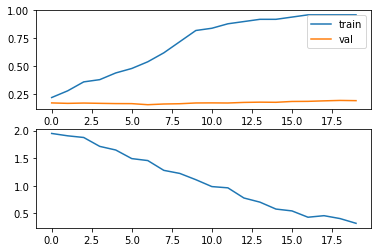

In [34]:
import matplotlib.pylab as plt

plt.subplot(2,1,1)
plt.plot(solver.train_acc_history)
plt.plot(solver.val_acc_history)
plt.legend(['train', 'val'])

plt.subplot(2,1,2)
plt.plot(solver.loss_history)
plt.show()